### Info

Segmentation performance of 3D U-Net on dHCP, FeTA2021 and Lucas Fidon (FeTA2021) were analyzed in this notebook. Train, val, and test sets of the FeTA2021 and Lucas Fidon have balanced distribution for ages and pathologic cases. 

In [1]:
import sys
sys.path.append('../../')

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchio as tio
import torchvision.transforms as transforms

from modules.Dataset import *
from modules import Evaluator3D, models
from modules.LossFunctions import DC_and_CE_loss, GDiceLossV2
from modules.Predictor import Predictor
from modules.Transforms import *
from modules.Utils import *

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path_dhcp = "../../Data/rel3_dhcp_anat_pipeline/"
path_feta = "../../Data/feta_pro2/"
path_fidon = "../../Data/lucas/"

# Transformations.
transform_eval = None

# Split dataset.
dhcp_val = MRIDataset(Dhcp, "val", path_dhcp, transform=transform_eval)
dhcp_test = MRIDataset(Dhcp, "test", path_dhcp, transform=transform_eval)

feta_val = MRIDataset(FeTABalancedDistribution, "val", path_feta, transform=transform_eval)
feta_test = MRIDataset(FeTABalancedDistribution, "test", path_feta, transform=transform_eval)

fidon_val = MRIDataset(FeTABalancedDistribution, "val", path_fidon, transform=transform_eval)
fidon_test = MRIDataset(FeTABalancedDistribution, "test", path_fidon, transform=transform_eval)
fidon_val.meta_data = fidon_val.meta_data.drop(columns='Unnamed: 3')
fidon_test.meta_data = fidon_test.meta_data.drop(columns='Unnamed: 3')

torch.manual_seed(0)
dhcp_val_loader = torch.utils.data.DataLoader(dataset=dhcp_val, batch_size=1)
dhcp_test_loader = torch.utils.data.DataLoader(dataset=dhcp_test, batch_size=1)

feta_val_loader = torch.utils.data.DataLoader(dataset=feta_val, batch_size=1)
feta_test_loader = torch.utils.data.DataLoader(dataset=feta_test, batch_size=1)

fidon_val_loader = torch.utils.data.DataLoader(dataset=fidon_val, batch_size=1)
fidon_test_loader = torch.utils.data.DataLoader(dataset=fidon_test, batch_size=1)

In [4]:
criterion = DC_and_CE_loss({'batch_dice': True, 'smooth': 1e-5, 'do_bg': False, 'square': False}, {})

### Warning! 
Tensorboard event files contains validation scores, not test scores.

### dHCP

In [5]:
path_events_file = '../../output/UNet3D/Iteration_20222812/run_dHCP2/events.out.tfevents.1672769584.DESKTOP-BN0TMAF.17592.0'
results = read_scalars(path_events_file, -1)
print(f"Validation loss {results['Validation loss']}")

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Epoch:  37
Validation loss -0.9066


In [6]:
unet3d = models.UNet3D().to(device)
unet3d.load_state_dict(torch.load("../../output/UNet3D/Iteration_20222812/run_dHCP2/weights/36_model.pth"))

predictor = Predictor(unet3d, (128, 128, 128))
sub = dhcp_test[0]

Validation : 100%|████████████████████████████████████| 13/13 [01:05<00:00,  5.06s/it, Loss: -0.9066]


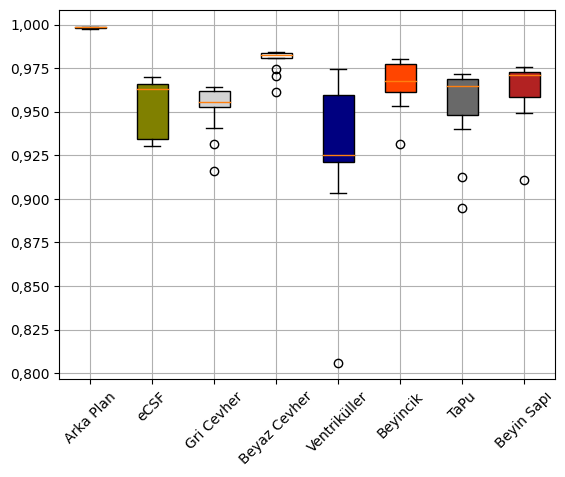

,0,1,2,3,4,5,6,7
0,0.998151,0.954066,0.951896,0.979604,0.929018,0.966449,0.953637,0.962672


In [7]:
evaluator = Evaluator3D(criterion, unet3d, (128, 128, 128), dhcp_val_loader)
_, scores = evaluator.evaluate()
avg_scores = print_evaluation_results(scores, dhcp_val, lang='tr')
pd.DataFrame(avg_scores).T

Validation : 100%|███████████████████████████████████████████████████| 13/13 [01:31<00:00,  7.04s/it]


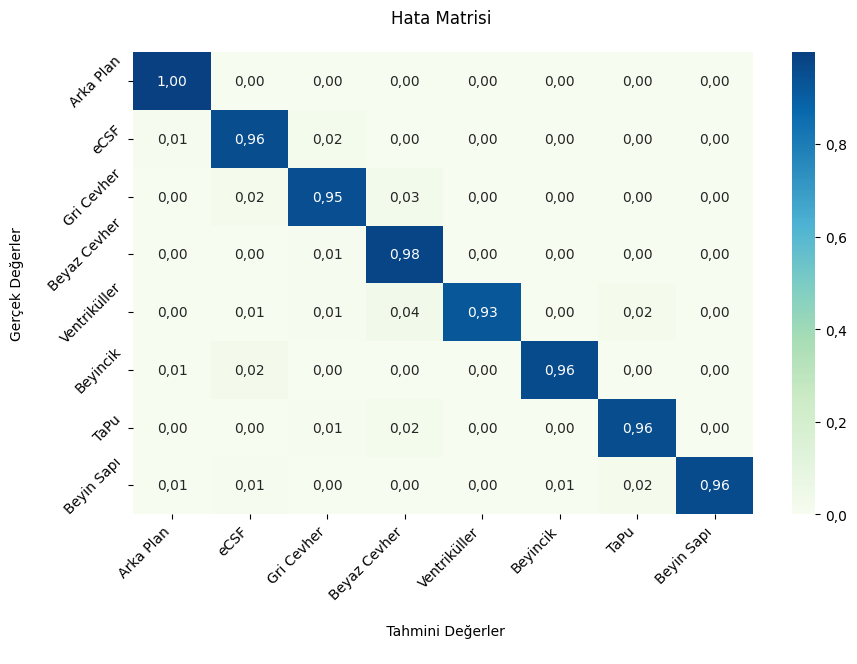

In [8]:
evaluator.calculate_cm()
evaluator.plot_confusion_matrix(lang='tr')

Validation : 100%|████████████████████████████████████| 13/13 [01:08<00:00,  5.26s/it, Loss: -0.8514]


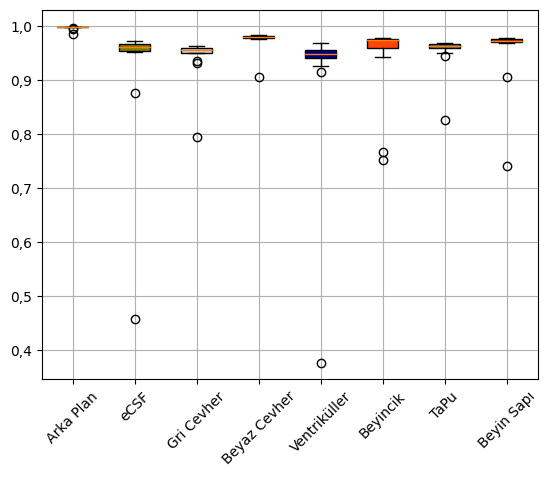

,0,1,2,3,4,5,6,7
0,0.996979,0.916881,0.941031,0.974063,0.90384,0.937171,0.950631,0.950083


In [9]:
tester = Evaluator3D(criterion, unet3d, (128, 128, 128), dhcp_test_loader)
_, scores = tester.evaluate()
avg_scores = print_evaluation_results(scores, dhcp_test, lang='tr')
pd.DataFrame(avg_scores).T

Validation : 100%|███████████████████████████████████████████████████| 13/13 [01:36<00:00,  7.43s/it]


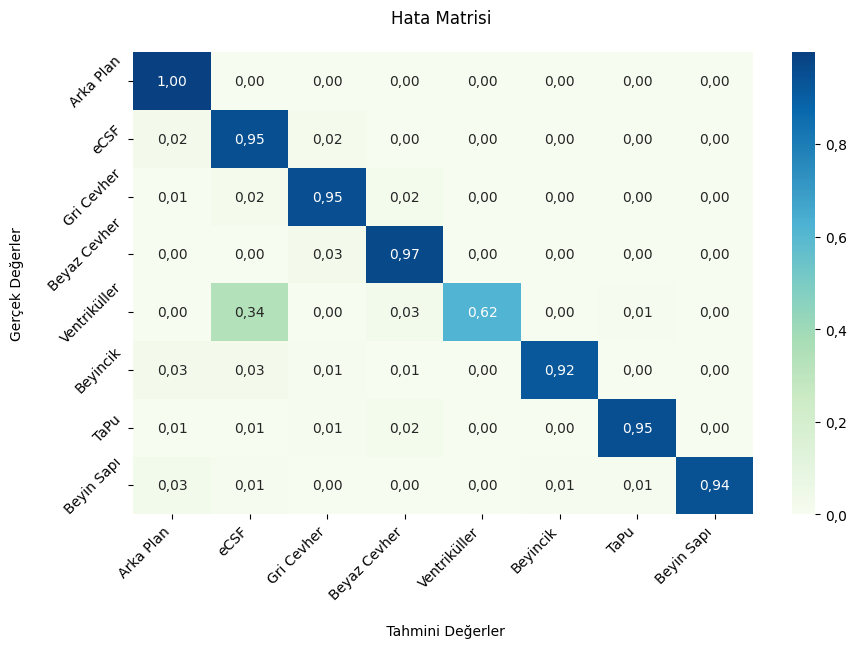

In [10]:
tester.calculate_cm()
tester.plot_confusion_matrix(lang='tr')

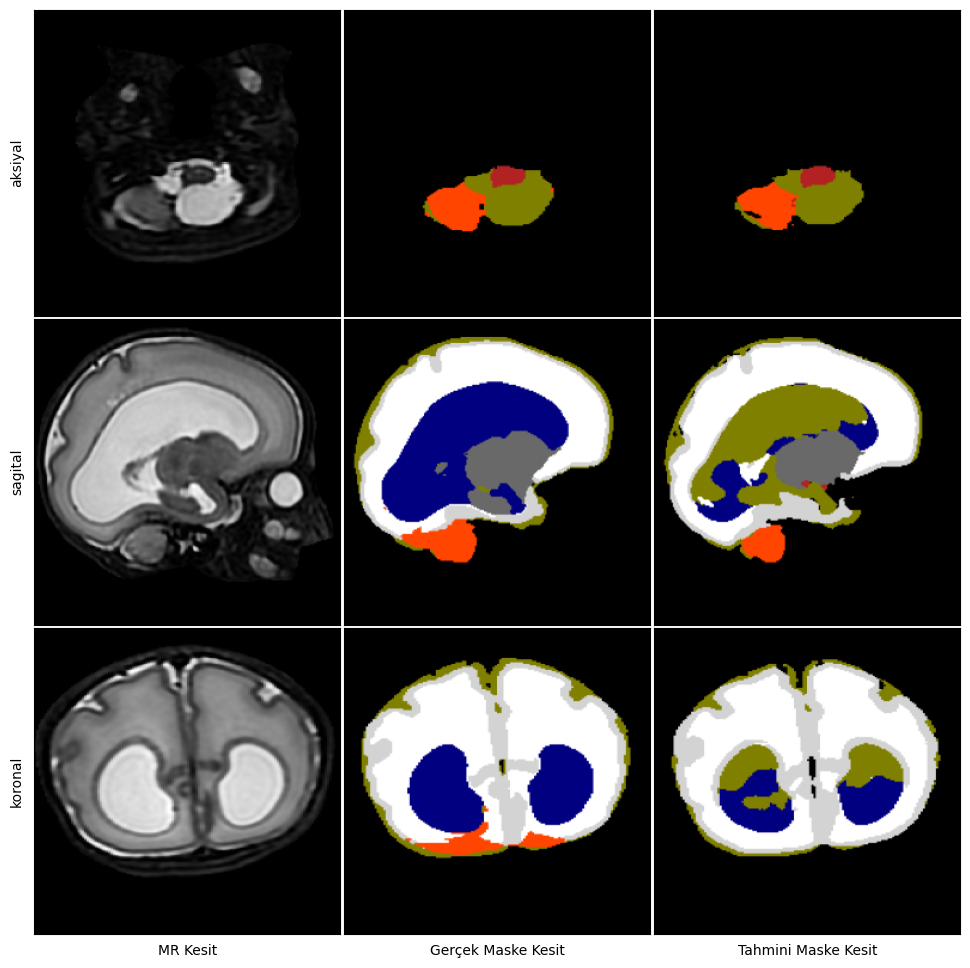

In [11]:
prediction = predictor.predict(sub)
pred_mask = torch.argmax(prediction, dim=1)
slice_idx = 45

plot_sub_orient(sub.mri.data, sub.mask.data, pred_mask, slice_idx)

### FeTA2021

In [12]:
path_events_file = '../../output/UNet3D/Iteration_20230103/FeTABalanced_feta_pro2/events.out.tfevents.1672769842.DESKTOP-SSDSQSH.5284.0'
results = read_scalars(path_events_file, -1)
print(f"Validation loss {results['Validation loss']}")

Epoch:  31
Validation loss -0.7444


In [13]:
unet3d.load_state_dict(torch.load("../../output/UNet3D/Iteration_20230103/FeTABalanced_feta_pro2/weights/30_model.pth"))

predictor = Predictor(unet3d, (128, 128, 128))
sub = feta_test[4]

Validation : 100%|████████████████████████████████████| 10/10 [00:57<00:00,  5.77s/it, Loss: -0.7444]


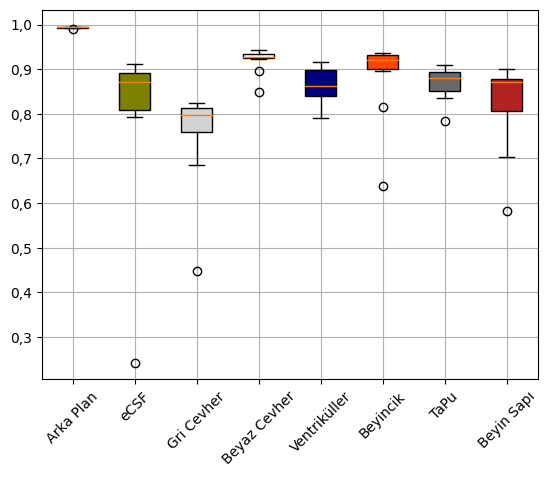

,0,1,2,3,4,5,6,7
0,0.994187,0.801797,0.753518,0.919646,0.863265,0.88348,0.867653,0.820727


In [14]:
evaluator = Evaluator3D(criterion, unet3d, (128, 128, 128), feta_val_loader)
_, scores = evaluator.evaluate()
avg_scores = print_evaluation_results(scores, feta_val, lang='tr')
pd.DataFrame(avg_scores).T

Validation : 100%|███████████████████████████████████████████████████| 10/10 [01:21<00:00,  8.20s/it]


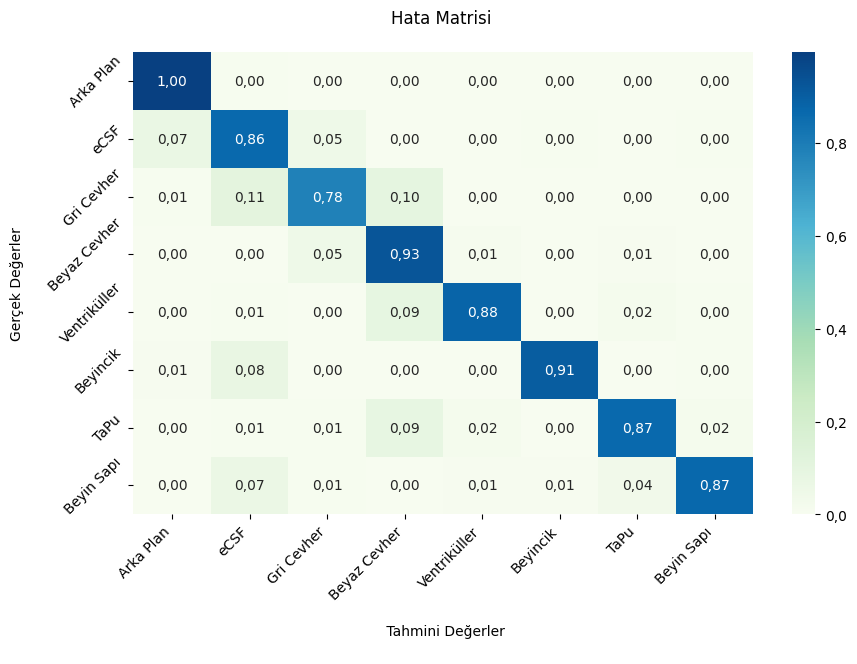

In [15]:
evaluator.calculate_cm()
evaluator.plot_confusion_matrix(lang='tr')

Validation : 100%|████████████████████████████████████| 10/10 [01:03<00:00,  6.32s/it, Loss: -0.6763]


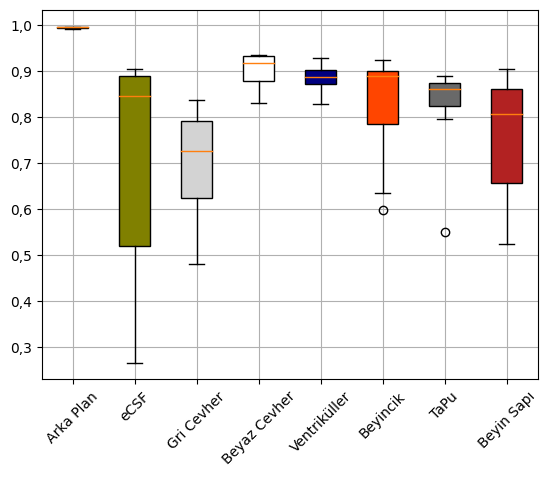

,0,1,2,3,4,5,6,7
0,0.993568,0.706476,0.693351,0.902604,0.884626,0.827709,0.824861,0.760285


In [16]:
tester = Evaluator3D(criterion, unet3d, (128, 128, 128), feta_test_loader)
_, scores = tester.evaluate()
avg_scores = print_evaluation_results(scores, feta_test, lang='tr')
pd.DataFrame(avg_scores).T

Validation : 100%|███████████████████████████████████████████████████| 10/10 [01:31<00:00,  9.16s/it]


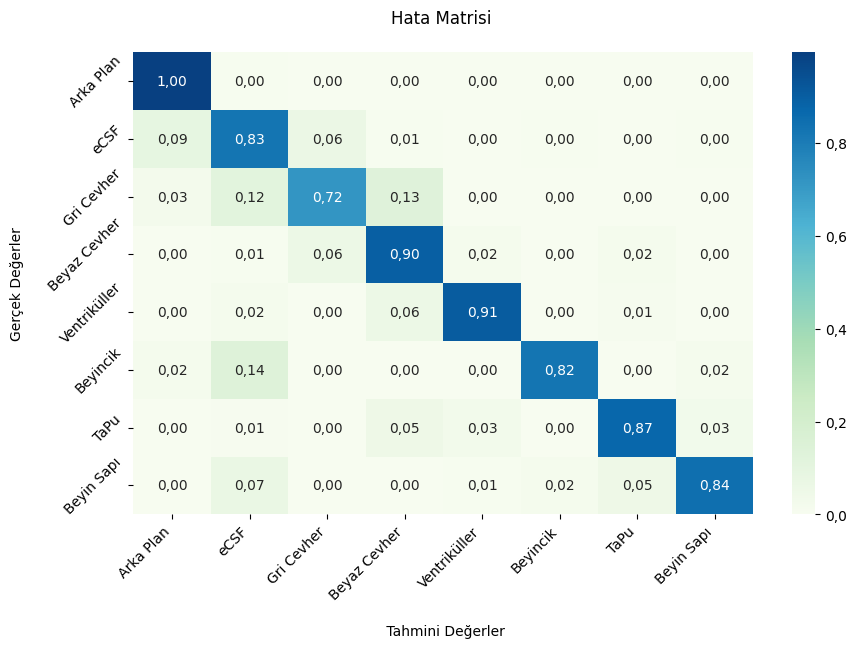

In [17]:
tester.calculate_cm()
tester.plot_confusion_matrix(lang='tr')

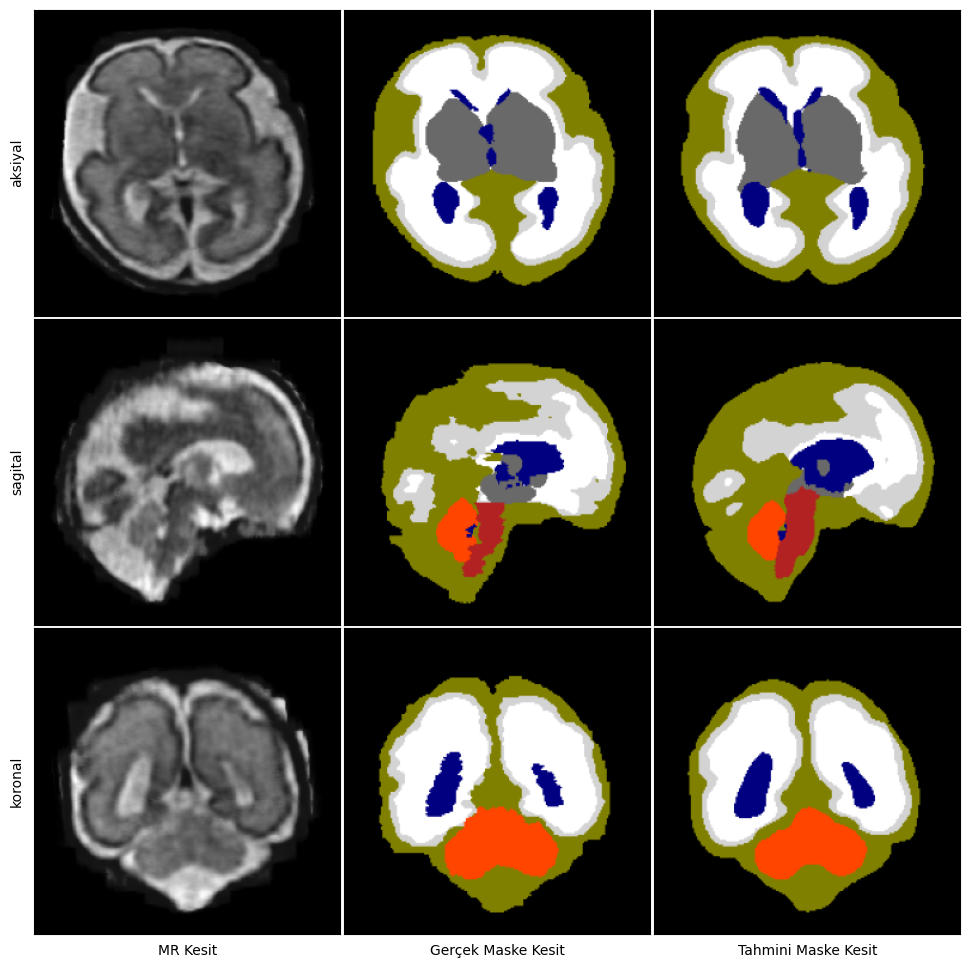

In [18]:
prediction = predictor.predict(sub)
pred_mask = torch.argmax(prediction, dim=1)
slice_idx = 90

plot_sub_orient(sub.mri.data, sub.mask.data, pred_mask, slice_idx)

### Fidon

In [19]:
path_events_file = '../../output/UNet3D/Iteration_20230103/FeTABalanced_lucas/events.out.tfevents.1672826536.DESKTOP-BN0TMAF.9864.0'
results = read_scalars(path_events_file, -1)
print(f"Validation loss {results['Validation loss']}")

Epoch:  20
Validation loss -0.8424


In [20]:
unet3d.load_state_dict(torch.load("../../output/UNet3D/Iteration_20230103/FeTABalanced_lucas/weights/19_model.pth"))

predictor = Predictor(unet3d, (128, 128, 128))
sub = fidon_test[4]

Validation : 100%|████████████████████████████████████| 10/10 [00:43<00:00,  4.32s/it, Loss: -0.8424]


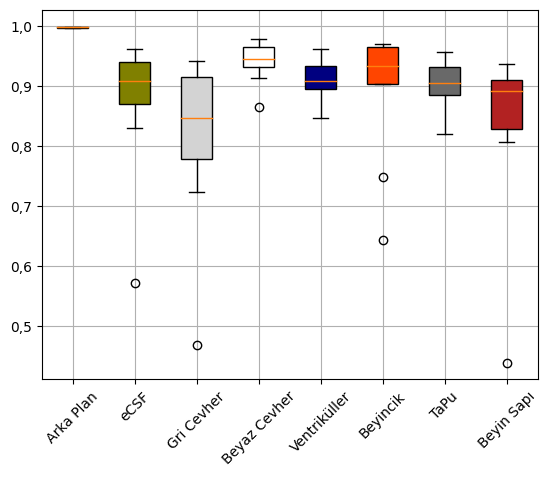

,0,1,2,3,4,5,6,7
0,0.998264,0.875479,0.816296,0.941387,0.912247,0.893473,0.904006,0.838066


In [21]:
evaluator = Evaluator3D(criterion, unet3d, (128, 128, 128), fidon_val_loader)
_, scores = evaluator.evaluate()
avg_scores = print_evaluation_results(scores, fidon_val, lang='tr')
pd.DataFrame(avg_scores).T

Validation : 100%|███████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.71s/it]


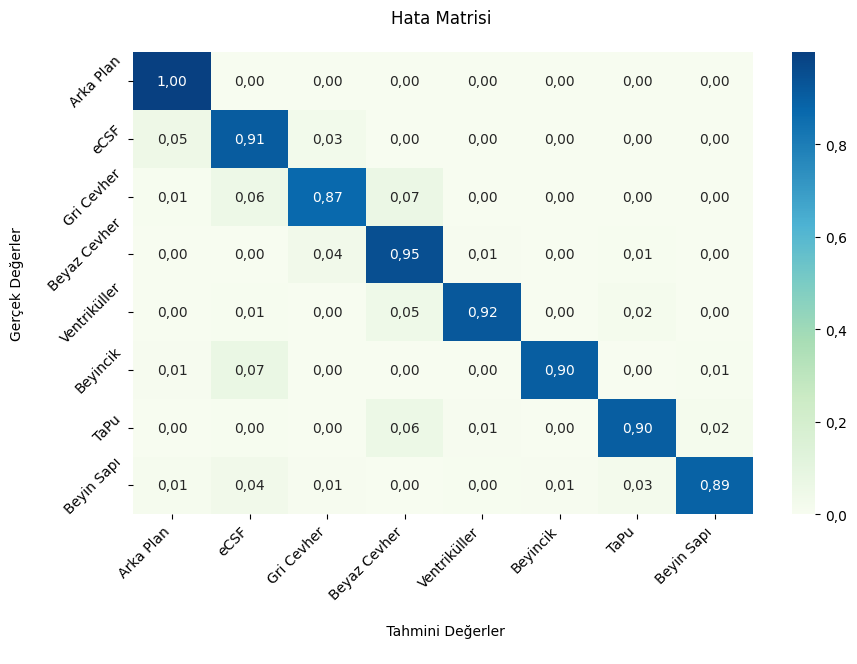

In [22]:
evaluator.calculate_cm()
evaluator.plot_confusion_matrix(lang='tr')

Validation : 100%|████████████████████████████████████| 10/10 [00:43<00:00,  4.35s/it, Loss: -0.8196]


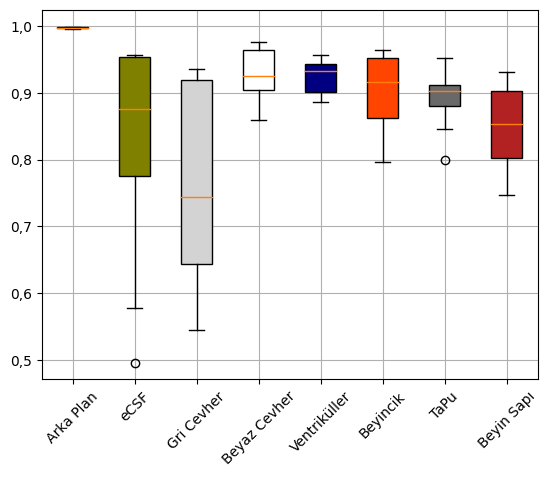

,0,1,2,3,4,5,6,7
0,0.997932,0.824551,0.764364,0.927237,0.923775,0.903206,0.894308,0.85018


In [23]:
tester = Evaluator3D(criterion, unet3d, (128, 128, 128), fidon_test_loader)
_, scores = tester.evaluate()
avg_scores = print_evaluation_results(scores, fidon_test, lang='tr')
pd.DataFrame(avg_scores).T

Validation : 100%|███████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.74s/it]


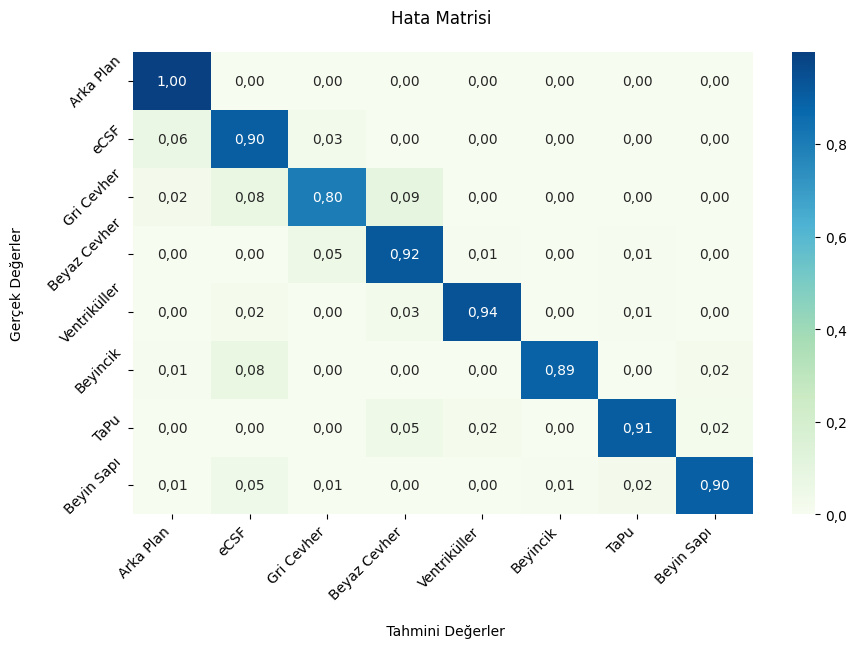

In [24]:
tester.calculate_cm()
tester.plot_confusion_matrix(lang='tr')

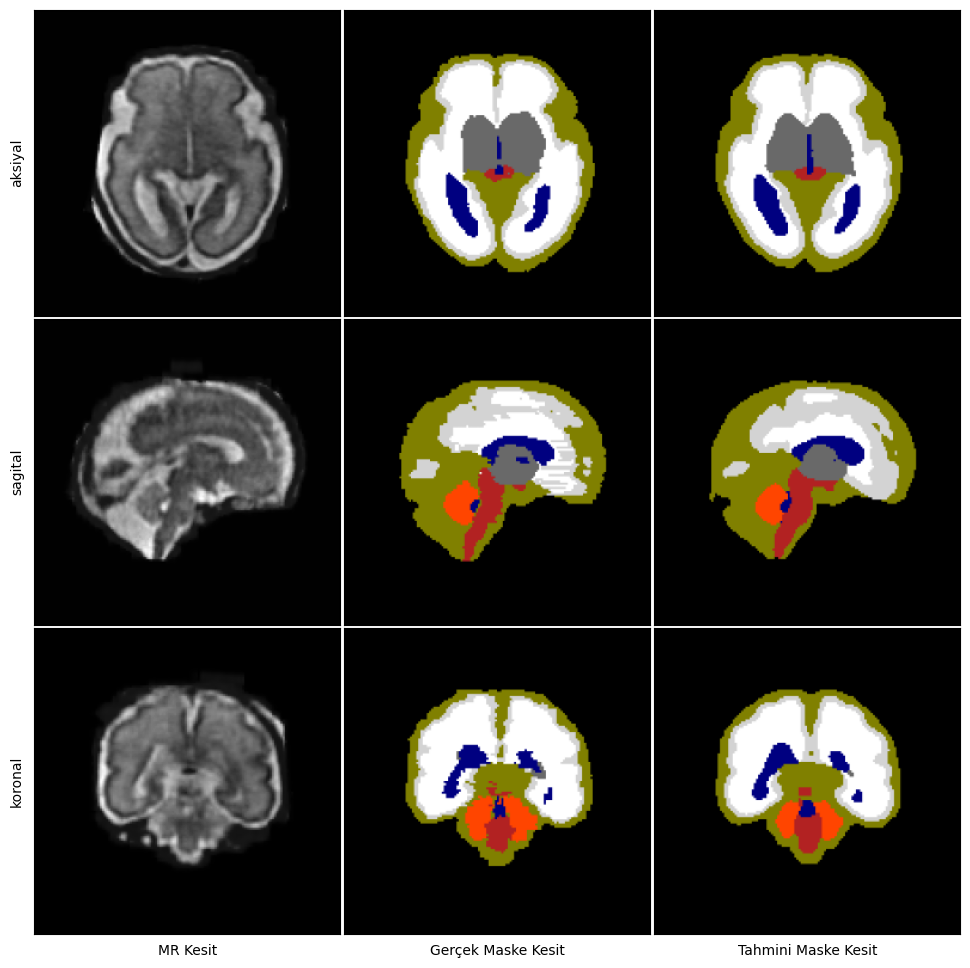

In [25]:
prediction = predictor.predict(sub)
pred_mask = torch.argmax(prediction, dim=1)
slice_idx = 70

plot_sub_orient(sub.mri.data, sub.mask.data, pred_mask, slice_idx)